In [26]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sensorflow_model.dataset import get_dataset


In [27]:

ACTIVITY_CLASSES = {
    0: "Sitting + Typing on Desk",
    1: "Sitting + Taking Notes", 
    2: "Standing + Writing on Whiteboard",
    3: "Standing + Erasing Whiteboard",
    4: "Sitting + Talking + Waving Hands",
    5: "Standing + Talking + Waving Hands",
    6: "Sitting + HeadNodding",
    7: "Sitting + Drinking Water",
    8: "Sitting + Drinking Coffee",
    9: "Standing + Drinking Water",
    10: "Standing + Drinking Coffee",
    11: "Scrolling on Phone",
}


In [28]:
model = load_model("../final_model.keras")

c:\Users\mohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [29]:

def normalize_with_saved_stats(X, stats_path="../normalization.json"):
    with open(stats_path, "r") as f:
        stats = json.load(f)

    mean = np.array(stats["mean"])
    std = np.array(stats["std"])
    X_flat = X.reshape(-1, X.shape[-1])
    X_scaled = (X_flat - mean) / std
    return X_scaled.reshape(X.shape)

In [30]:
# STEP 2: Load and preprocess test data
def load_tsne_data(folder_path):
    X_all, y_all = [], []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            path = os.path.join(folder_path, file)
            X, y = get_dataset(path, window_size=20, stride=5, normalize=False)
            X_all.append(X)
            y_all.append(y)
    return np.concatenate(X_all), np.concatenate(y_all)


In [31]:

X_raw, y = load_tsne_data("../TestData/without")  
X = normalize_with_saved_stats(X_raw)


In [32]:
# feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)


# For Sequential models, use the first layer's input as input
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [33]:
# Pad X to have 200 time steps (pad at the end with zeros)
if X.shape[1] < 200:
	pad_width = ((0, 0), (0, 200 - X.shape[1]), (0, 0))
	X_padded = np.pad(X, pad_width, mode='constant')
else:
	X_padded = X

features = feature_extractor.predict(X_padded, batch_size=128, verbose=1)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


In [34]:

# STEP 4: t-SNE Embed
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
features_2d = tsne.fit_transform(features)

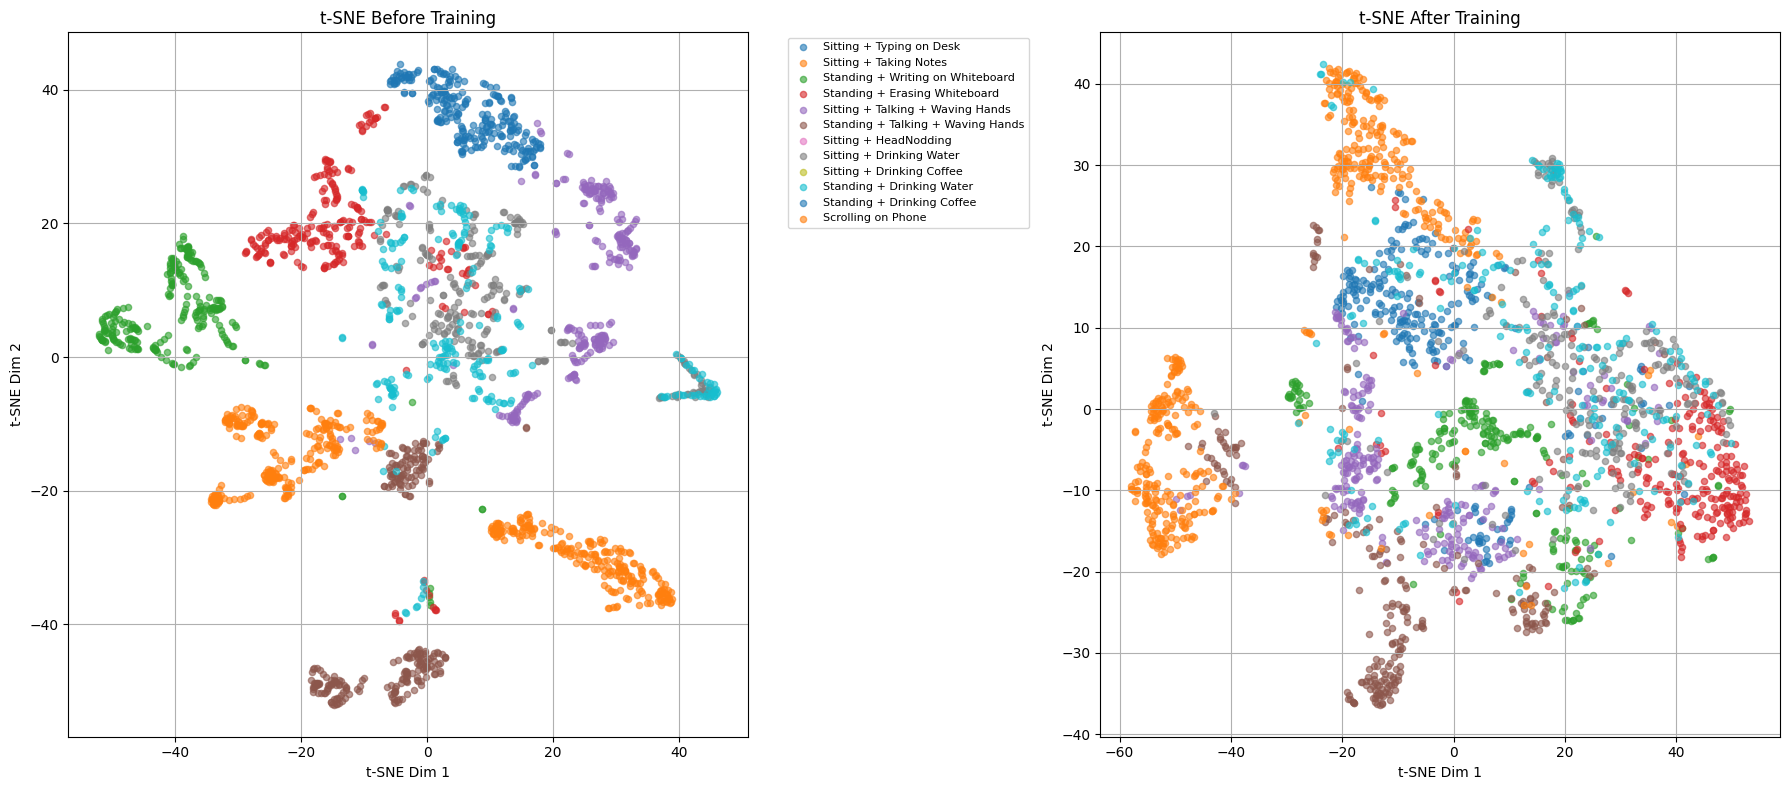

In [35]:
# Compute t-SNE before training (on mean-pooled input features)
X_flat = X.mean(axis=1)  # shape: (num_samples, num_features)
tsne_before = TSNE(n_components=2, random_state=42, perplexity=40)
X_2d_before = tsne_before.fit_transform(X_flat)

plt.figure(figsize=(18, 8))

# Before Training
plt.subplot(1, 2, 1)
for class_idx, class_name in ACTIVITY_CLASSES.items():
    idxs = np.where(y == class_idx)
    plt.scatter(X_2d_before[idxs, 0], X_2d_before[idxs, 1], label=class_name, alpha=0.6, s=20)
plt.title("t-SNE Before Training")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# After Training
plt.subplot(1, 2, 2)
for class_idx, class_name in ACTIVITY_CLASSES.items():
    idxs = np.where(y == class_idx)
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], label=class_name, alpha=0.6, s=20)
plt.title("t-SNE After Training")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)

plt.tight_layout()
plt.show()

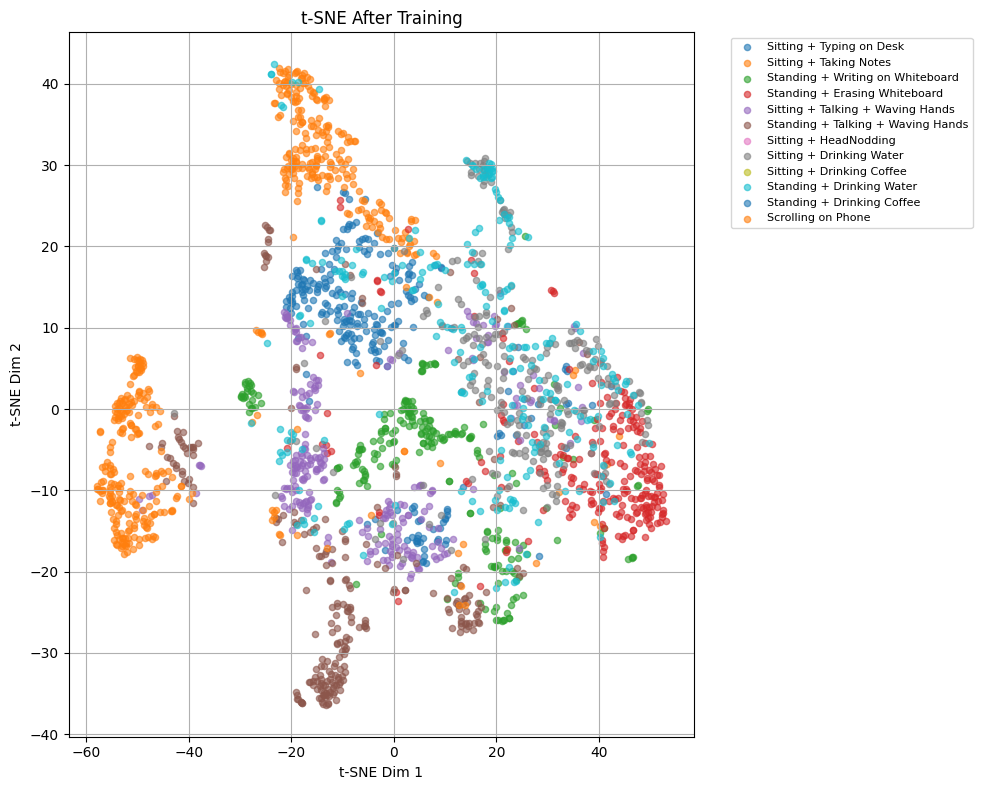

In [36]:
plt.figure(figsize=(10, 8))

for class_idx, class_name in ACTIVITY_CLASSES.items():
    idxs = np.where(y == class_idx)
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], label=class_name, alpha=0.6, s=20)
plt.title("t-SNE After Training")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()